# Analysis of the effect of starting locations on angular error in HumanA
author: Nora Maleki (noora.maleki@gmail.com)
April 2022

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy.stats as stats
import researchpy as rp


In [26]:
colorblind_palette = ['#2d004b', '#5ab4ac', '#b2182b', '#8c510a','#4575b4','#8073ac']
sns.set_theme(font_scale=1, palette=colorblind_palette, style='darkgrid')

## Load data

In [39]:
FILE_PATH = r'../../data/01_main'
PLOT_PATH = f'{FILE_PATH}/plots/analysis/'

os.makedirs(os.path.dirname(PLOT_PATH), exist_ok=True)

In [40]:
df_cleaned = pd.read_csv(f'{FILE_PATH}/07_preprocessed.csv')
df_cleaned.head()

,subject_id,body_pos_x,body_pos_z,pointer_pos_x,pointer_pos_z,pointer_dir_x,pointer_dir_z,building_center_z,building_center_x,human_agent,...,moved_target_position_z,target_to_x_180,dir_to_x_180,target_to_x_360,dir_to_x_360,final_180_angles,final_360_angles,rounded_180_angles,rounded_360_angles,absolute_180_angles
0,365,-114.329147,-139.997375,-114.236984,-139.696228,-0.055459,0.989548,53.288437,-72.578285,46,...,193.285812,77.811048,93.207763,77.811048,93.207763,15.396716,15.396716,15.0,15.0,15.396716
1,365,-65.669235,-159.945099,-65.474716,-159.710205,0.072550,0.992235,53.288437,-72.578285,46,...,213.233536,91.855810,85.818077,91.855810,85.818077,-6.037733,353.962267,-6.0,354.0,6.037733
2,365,38.849380,53.547638,38.471634,53.516281,-0.993265,-0.112792,53.288437,-72.578285,46,...,-0.259201,-179.866720,-173.521430,180.133280,186.478570,6.345290,6.345290,6.0,6.0,6.345290
3,365,38.880081,53.564148,38.700195,53.581047,-0.995648,-0.065598,53.288437,-72.578285,46,...,-0.275711,-179.858270,-176.230517,180.141730,183.769483,3.627752,3.627752,4.0,4.0,3.627752
4,365,110.754181,196.522675,110.428146,196.550751,-0.941145,-0.321944,53.288437,-72.578285,46,...,-143.234238,-142.000152,-161.115388,217.999848,198.884612,-19.115237,340.884763,-19.0,341.0,19.115237


## Linear Mixed Effects Models

In [29]:
lmm_df = (df_cleaned[['absolute_180_angles', 'RT', 'distance_to_target']]
           .assign(subject_id=df_cleaned.subject_id.astype('category'),
                   starting_loc_id=df_cleaned.starting_loc_id.astype('category'),
                   human_agent=df_cleaned.human_agent.astype('category'),
                   trial_id_per_location=df_cleaned.trial_id_per_location.astype('category'),
                   trial_id=df_cleaned.trial_id.astype('category')
                   ))

lmm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7708 entries, 0 to 7707
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   absolute_180_angles    7708 non-null   float64 
 1   RT                     7708 non-null   float64 
 2   distance_to_target     7708 non-null   float64 
 3   subject_id             7708 non-null   category
 4   starting_loc_id        7708 non-null   category
 5   human_agent            7708 non-null   category
 6   trial_id_per_location  7708 non-null   category
 7   trial_id               7708 non-null   category
dtypes: category(5), float64(3)
memory usage: 241.5 KB


In [30]:
N = lmm_df.subject_id.nunique()
N

23

In [31]:
rp.codebook(lmm_df)

Variable: absolute_180_angles    Data Type: float64 

 Number of Obs.: 7708 
 Number of missing obs.: 0 
 Percent missing: 0.0 
 Number of unique values: 7708 

 Range: [0.0098611111833122, 179.98338618386344] 
 Mean: 48.08 
 Standard Deviation: 44.3 
 Mode: 0.0098611111833122 
 10th Percentile: 4.061728074435263 
 25th Percentile: 12.864763109725658 
 50th Percentile: 33.697730978897454 
 75th Percentile: 71.5482171723512 
 90th Percentile: 117.0012642321176 





Variable: RT    Data Type: float64 

 Number of Obs.: 7708 
 Number of missing obs.: 0 
 Percent missing: 0.0 
 Number of unique values: 7684 

 Range: [0.955792665481567, 29.289794206619263] 
 Mean: 7.77 
 Standard Deviation: 5.56 
 Mode: 1.3769052028656 
 10th Percentile: 2.431258296966553 
 25th Percentile: 3.621542990207672 
 50th Percentile: 6.063600659370422 
 75th Percentile: 10.153734385967253 
 90th Percentile: 15.809007906913761 





Variable: distance_to_target    Data Type: float64 

 Number of Obs.: 7708 
 Numb

In [32]:
rp.summary_cont(lmm_df.groupby(['starting_loc_id',])['absolute_180_angles'])

,N,Mean,SD,SE,95% Conf.,Interval
starting_loc_id,,,,,,
1,276,46.7310,41.6004,2.5041,41.8014,51.6605
2,276,33.5257,30.9483,1.8629,29.8584,37.1930
4,276,45.7968,43.7805,2.6353,40.6089,50.9846
5,276,62.7748,51.2321,3.0838,56.7040,68.8457
7,274,38.7264,39.5038,2.3865,34.0281,43.4247
9,276,27.5027,26.7153,1.6081,24.3370,30.6684
14,276,41.3706,40.0602,2.4113,36.6236,46.1176
18,274,51.9744,48.8015,2.9482,46.1703,57.7786
19,276,43.0256,42.7547,2.5735,37.9593,48.0920


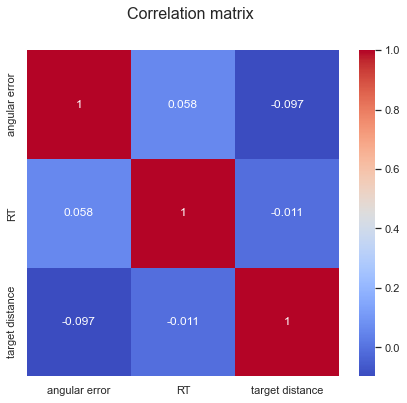

In [33]:
fig, axes = plt.subplots(figsize = (7, 6))

sns.heatmap(
    data=(lmm_df
          .rename(columns={'absolute_180_angles' : 'angular error',
                           'distance_to_target' : 'target distance'})
          .corr()),
    annot = True,
    fmt='.2g',
    cmap= 'coolwarm'
)

plt.suptitle(t='Correlation matrix', size=16, x=.45)

plt.show()

fig.savefig(f'{PLOT_PATH}/correlation_matrix_{N}.png', bbox_inches='tight', dpi=90)

### Random Intercept model

#### Angular deviation

##### Predicting `angular error` based on `starting location`, `distance to target` and `human agent / building`

Find the starting location id of the location closest to the center of locations
_(this will be used as the reference location for the analysis)_

In [45]:
df_cleaned[df_cleaned.distance_to_center_of_locations == min(df_cleaned.distance_to_center_of_locations)][['starting_loc_id', 'distance_to_center_of_locations']].iloc[0,:]

starting_loc_id                     5.000000
distance_to_center_of_locations    27.763098
Name: 60, dtype: float64

In [38]:
formula = 'absolute_180_angles ~ C(starting_loc_id, Treatment(reference=5))'

model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM.summary())

                             Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           absolute_180_angles
No. Observations:           7708              Method:                       REML               
No. Groups:                 23                Scale:                        1713.9889          
Min. group size:            329               Log-Likelihood:               -39610.1276        
Max. group size:            336               Converged:                    Yes                
Mean group size:            335.1                                                              
-----------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------------------------
Intercept                                         62.775    3.717  16

In [48]:
model_LM.random_effects

{365: subject_id    7.81794
 dtype: float64,
 479: subject_id   -22.055755
 dtype: float64,
 1754: subject_id    13.666454
 dtype: float64,
 2258: subject_id   -16.453498
 dtype: float64,
 3246: subject_id   -11.359021
 dtype: float64,
 3572: subject_id    1.32921
 dtype: float64,
 3976: subject_id   -5.66387
 dtype: float64,
 4176: subject_id   -24.392943
 dtype: float64,
 4796: subject_id    10.938194
 dtype: float64,
 5238: subject_id    6.853239
 dtype: float64,
 5531: subject_id    14.245089
 dtype: float64,
 5741: subject_id    10.367571
 dtype: float64,
 6642: subject_id   -13.140607
 dtype: float64,
 7093: subject_id    5.201349
 dtype: float64,
 7264: subject_id    10.535795
 dtype: float64,
 7412: subject_id   -22.674788
 dtype: float64,
 7842: subject_id    6.97044
 dtype: float64,
 8007: subject_id    16.733609
 dtype: float64,
 8469: subject_id   -4.286814
 dtype: float64,
 8695: subject_id   -0.354718
 dtype: float64,
 9472: subject_id    14.075685
 dtype: float64,
 9502:

In [35]:
model_LM.params

Intercept                                            45.234103
C(starting_loc_id, Treatment(reference=10))[T.1]      1.496852
C(starting_loc_id, Treatment(reference=10))[T.2]    -11.708435
C(starting_loc_id, Treatment(reference=10))[T.4]      0.562651
C(starting_loc_id, Treatment(reference=10))[T.5]     17.540730
C(starting_loc_id, Treatment(reference=10))[T.7]     -6.477824
C(starting_loc_id, Treatment(reference=10))[T.9]    -17.731362
C(starting_loc_id, Treatment(reference=10))[T.14]    -3.863518
C(starting_loc_id, Treatment(reference=10))[T.18]     6.764061
C(starting_loc_id, Treatment(reference=10))[T.19]    -2.208465
C(starting_loc_id, Treatment(reference=10))[T.20]     2.831692
C(starting_loc_id, Treatment(reference=10))[T.25]    -6.023569
C(starting_loc_id, Treatment(reference=10))[T.29]    11.618412
C(starting_loc_id, Treatment(reference=10))[T.30]    14.418868
C(starting_loc_id, Treatment(reference=10))[T.34]     1.758498
C(starting_loc_id, Treatment(reference=10))[T.35]    20

In [19]:
formula = 'absolute_180_angles ~ C(starting_loc_id) + distance_to_target + C(trial_id, Treatment(reference=336))'

model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM.summary())

                          Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         absolute_180_angles
No. Observations:          7708            Method:                     REML               
No. Groups:                23              Scale:                      1708.8779          
Min. group size:           329             Log-Likelihood:             -38401.8516        
Max. group size:           336             Converged:                  Yes                
Mean group size:           335.1                                                          
------------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------------------------
Intercept                                     52.430    9.502  5.518 0.000  33.807  71.052
C(starting_loc_id)[T.2]   

In [48]:
# icc
0.177 / 1.7067

0.10370891193531376

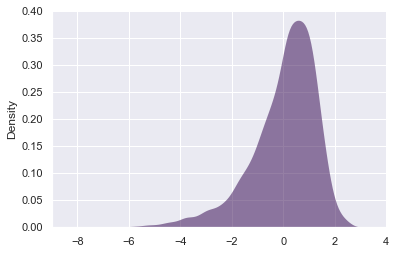

In [49]:
sns.kdeplot(model_LM.resid, shade='fill', palette='Crest', alpha=.5, linewidth=0)
plt.show()

In [50]:
formula = 'np.log(absolute_180_angles) ~ C(starting_loc_id, Treatment(reference=27)) + distance_to_target + C(trial_id_per_location, Treatment(reference=12))'

model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM.summary())

                              Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         np.log(absolute_180_angles)
No. Observations:          7708            Method:                     REML                       
No. Groups:                23              Scale:                      1.7069                     
Min. group size:           329             Log-Likelihood:             -13092.1128                
Max. group size:           336             Converged:                  Yes                        
Mean group size:           335.1                                                                  
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

In [51]:
# icc
0.177 / 1.7067

0.10370891193531376

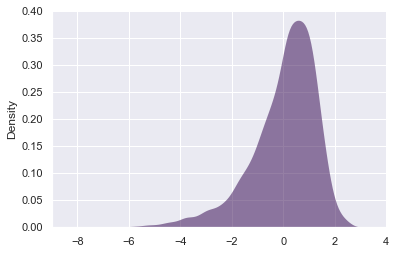

In [52]:
sns.kdeplot(model_LM.resid, shade='fill', palette='Crest', alpha=.5, linewidth=0)
plt.show()

##### Predicting `angular error` based on `starting location` and `distance to target`

In [13]:
formula = 'absolute_180_angles ~ C(starting_loc_id) + distance_to_target + C(trial_id_per_location) + distance_to_target:C(trial_id_per_location)'

model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM.summary())

                             Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           absolute_180_angles
No. Observations:           7708              Method:                       REML               
No. Groups:                 23                Scale:                        1709.5923          
Min. group size:            329               Log-Likelihood:               -39614.2431        
Max. group size:            336               Converged:                    Yes                
Mean group size:            335.1                                                              
-----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------------------------
Intercept                                          52.253    5.273  9

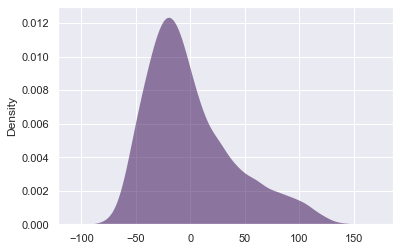

In [14]:
sns.kdeplot(model_LM.resid, shade='fill', palette='Crest', alpha=.5, linewidth=0)
plt.show()

In [55]:
formula = 'np.log(absolute_180_angles) ~ C(starting_loc_id, Treatment(reference=27)) + distance_to_target'

model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM.summary())

                           Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       np.log(absolute_180_angles)
No. Observations:        7708          Method:                   REML                       
No. Groups:              23            Scale:                    1.7065                     
Min. group size:         329           Log-Likelihood:           -13075.3181                
Max. group size:         336           Converged:                Yes                        
Mean group size:         335.1                                                              
--------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                          3.558    0.121 29.472 0.000  3.321  3.795
C(sta

In [56]:
# icc
0.177 / 1.7065

0.1037210665104014

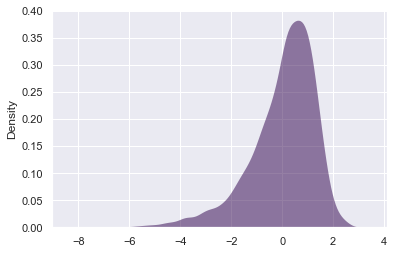

In [57]:
sns.kdeplot(model_LM.resid, shade='fill', palette='Crest', alpha=.5, linewidth=0)
plt.show()

##### Predicting `angular error` based on `starting location`

In [15]:
formula = 'absolute_180_angles ~ C(starting_loc_id)'

model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM.summary())

                Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  absolute_180_angles
No. Observations:    7708     Method:              REML               
No. Groups:          23       Scale:               1713.9889          
Min. group size:     329      Log-Likelihood:      -39610.1276        
Max. group size:     336      Converged:           Yes                
Mean group size:     335.1                                            
----------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------
Intercept                 46.731    3.717 12.574 0.000  39.447  54.015
C(starting_loc_id)[T.2]  -13.205    3.524 -3.747 0.000 -20.113  -6.298
C(starting_loc_id)[T.4]   -0.934    3.524 -0.265 0.791  -7.842   5.973
C(starting_loc_id)[T.5]   16.044    3.524  4.552 0.000   9.137  22.951
C(starting_loc_id)[T.7]

In [ ]:
# AIC

In [58]:
# icc
0.177 / 1.7064

0.10372714486638537

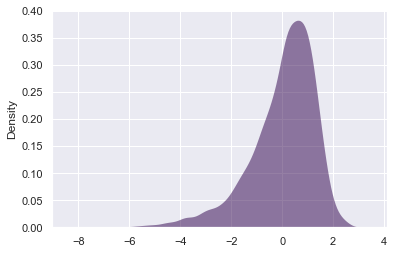

In [59]:
sns.kdeplot(model_LM.resid, shade='fill', palette='Crest', alpha=.5, linewidth=0)
plt.show()

##### Predicting `angular error` based on `distance to target`

In [60]:
formula = 'np.log(absolute_180_angles) ~ distance_to_target'

# Define and fit a linear regression model
model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id').fit()
print(model_LM.summary())

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: np.log(absolute_180_angles)
No. Observations: 7708    Method:             REML                       
No. Groups:       23      Scale:              1.7466                     
Min. group size:  329     Log-Likelihood:     -13135.9430                
Max. group size:  336     Converged:          Yes                        
Mean group size:  335.1                                                  
---------------------------------------------------------------------------
                       Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------------
Intercept               3.324      0.094   35.342   0.000    3.140    3.509
distance_to_target     -0.000      0.000   -2.302   0.021   -0.000   -0.000
subject_id Var          0.176      0.041                                   



In [63]:
# icc
0.176 / 1.7466

0.10076720485514715

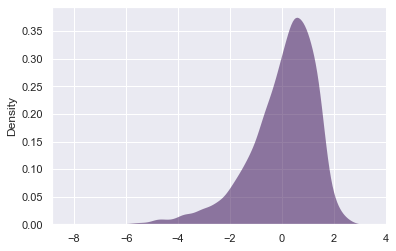

In [62]:
sns.kdeplot(model_LM.resid, shade='fill', palette='Crest', alpha=.5, linewidth=0)
plt.show()

## Random slope model

In [66]:
formula = 'np.log(absolute_180_angles) ~ C(starting_loc_id, Treatment(reference=27)) + C(human_agent)'

# Define and fit a linear regression model
model_LM = smf.mixedlm(formula = formula, data = lmm_df, groups='subject_id', vc_formula = {'human_agent' : '0 + C(human_agent)'}).fit()
print(model_LM.summary())

                           Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       np.log(absolute_180_angles)
No. Observations:        7708          Method:                   REML                       
No. Groups:              23            Scale:                    1.4526                     
Min. group size:         329           Log-Likelihood:           -12970.9979                
Max. group size:         336           Converged:                Yes                        
Mean group size:         335.1                                                              
--------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                          3.302    0.175 18.850 0.000  2.959  3.646
C(sta